# **Import**

In [ ]:
import os
import zipfile

# Path to the zip file and the directory to extract
zip_path = '/content/drive/MyDrive/data/train.zip'
extract_path = '/content/train'

# Ensure the zip file exists
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"Zip file '{zip_path}' does not exist. Please check the path.")

# Extract the zip file if the directory does not exist
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# List the contents of the extracted directory to debug
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f'{subindent}{f}')


Streaming output truncated to the last 5000 lines.
                ._non_COVID (11918).png
                ._Normal-3591.png
                ._Normal-1550.png
                ._Normal-9723.png
                ._Normal-6912.png
                ._Normal-1515.png
                ._Normal-4083.png
                ._Normal-9551.png
                ._Normal-5987.png
                ._Normal-1136.png
                ._Normal-409.png
                ._Normal-6541.png
                ._Normal (9739).png
                ._Normal-2713.png
                ._Normal-9283.png
                ._Normal-3477.png
                ._Normal-5188.png
                ._Normal-7750.png
                ._Normal-5456.png
                ._Normal-4022.png
                ._Normal-2348.png
                ._Normal-6900.png
                ._Normal-4317.png
                ._Normal-5810.png
                ._Normal-3937.png
                ._non_COVID (3269).png
                ._07cdb450-541e-4810-900b-b3b7b9846e8

## Custom Training

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from google.colab import drive
import zipfile
from PIL import Image

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

path = '/content/drive/MyDrive/data/train.zip'
extract_path = '/content/drive/MyDrive/data/train'

# Ensure the zip file exists
if not os.path.exists(path):
    raise FileNotFoundError(f"Zip file '{path}' does not exist. Please check the path.")

# Extract the zip file if the directory does not exist
if not os.path.exists(extract_path):
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Ensure subdirectories exist
classes = ['COVID', 'Normal', 'Pneumonia']
for cls in classes:
    if not os.path.exists(os.path.join(extract_path, 'train', cls)):
        raise FileNotFoundError(f"Subdirectory '{os.path.join(extract_path, 'train', cls)}' does not exist. Please check the path.")

# Custom Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load image paths and labels
image_paths = []
labels = []

for idx, cls in enumerate(classes):
    cls_dir = os.path.join(extract_path, 'train', cls)
    cls_paths = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir) if img.endswith('.jpg')]
    image_paths.extend(cls_paths)
    labels.extend([idx] * len(cls_paths))

# Split the data into training and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create datasets and dataloaders
train_dataset = CustomImageDataset(train_paths, train_labels, transform=transform)
test_dataset = CustomImageDataset(test_paths, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 18 * 18, 512)  # Adjust size based on the input image dimensions
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 3)  # Output layer for 3 classes

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 18 * 18)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

# Evaluating the model
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())

accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy}')

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/x0.0.pth')


Mounted at /content/drive
Epoch 1/25, Loss: 13.512894309484041
Epoch 2/25, Loss: 3.400822098438556
Epoch 3/25, Loss: 1.5995298394790063
Epoch 4/25, Loss: 1.8771762962524707
Epoch 5/25, Loss: 0.8753030586701173
Epoch 6/25, Loss: 0.3483987868978427
Epoch 7/25, Loss: 0.28763052133413464
Epoch 8/25, Loss: 0.3652550566654939
Epoch 9/25, Loss: 0.24057227888932595
Epoch 10/25, Loss: 0.16819527086157066
Epoch 11/25, Loss: 0.1448767580665075
Epoch 12/25, Loss: 0.12271648530776684
Epoch 13/25, Loss: 0.09723229448382671
Epoch 14/25, Loss: 0.0919546062270036
Epoch 15/25, Loss: 0.09696607592587288
Epoch 16/25, Loss: 0.08933584188791709
Epoch 17/25, Loss: 0.061149072188597456
Epoch 18/25, Loss: 0.06776239063877326
Epoch 19/25, Loss: 0.053233283500258737
Epoch 20/25, Loss: 0.052291215039216556
Epoch 21/25, Loss: 0.049033572968955226
Epoch 22/25, Loss: 0.06622668040486482
Epoch 23/25, Loss: 0.08196991116095048
Epoch 24/25, Loss: 0.0754284645215823
Epoch 25/25, Loss: 0.12844446419666594
Test Accuracy: 

# Model training with cross validation
## Train-80% Devset-10% Test-10%

Mounted at /content/drive
Epoch 1/25, Train Loss: 11.124620015804584, Val Loss: 7.9149627685546875, Train Acc: 0.4849246231155779, Val Acc: 0.5510204081632653
Epoch 2/25, Train Loss: 3.182355353465447, Val Loss: 10.80647325515747, Train Acc: 0.7160804020100503, Val Acc: 0.5918367346938775
Epoch 3/25, Train Loss: 1.1947078315111308, Val Loss: 5.453875303268433, Train Acc: 0.7814070351758794, Val Acc: 0.5306122448979592
Epoch 4/25, Train Loss: 0.5288627376923194, Val Loss: 2.347918152809143, Train Acc: 0.8316582914572864, Val Acc: 0.5510204081632653
Epoch 5/25, Train Loss: 0.3788284332706378, Val Loss: 1.948041319847107, Train Acc: 0.8668341708542714, Val Acc: 0.6122448979591837
Epoch 6/25, Train Loss: 0.24952617918069547, Val Loss: 0.7810262441635132, Train Acc: 0.8969849246231156, Val Acc: 0.7959183673469388
Epoch 7/25, Train Loss: 0.2339010817500261, Val Loss: 0.6335312873125076, Train Acc: 0.907035175879397, Val Acc: 0.8367346938775511
Epoch 8/25, Train Loss: 0.17541360625853905, Val

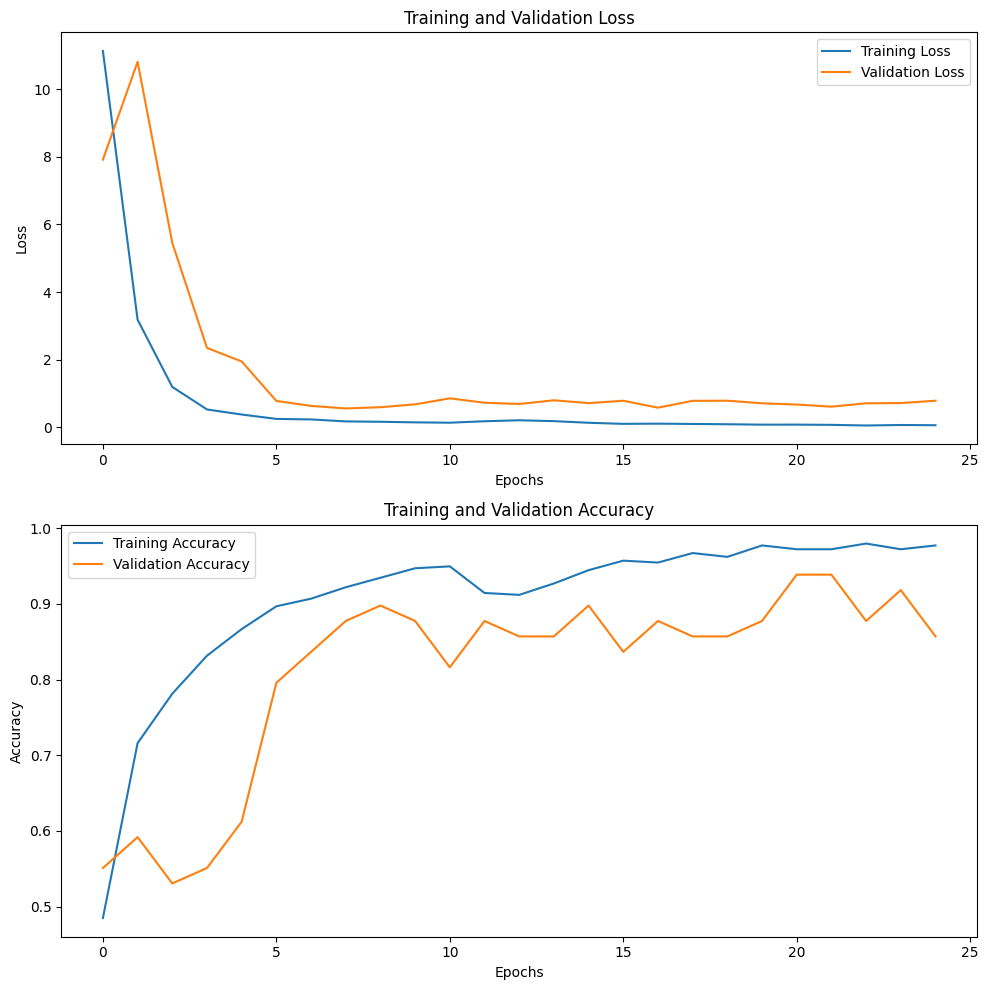

Test Accuracy: 0.8235294117647058


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from sklearn.metrics import accuracy_score
from google.colab import drive
import zipfile
from PIL import Image
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

path = '/content/drive/MyDrive/data/train.zip'
extract_path = '/content/drive/MyDrive/data/train'

# Ensure the zip file exists
if not os.path.exists(path):
    raise FileNotFoundError(f"Zip file '{path}' does not exist. Please check the path.")

# Extract the zip file if the directory does not exist
if not os.path.exists(extract_path):
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Ensure subdirectories exist
classes = ['COVID', 'Normal', 'Pneumonia']
for cls in classes:
    if not os.path.exists(os.path.join(extract_path, 'train', cls)):
        raise FileNotFoundError(f"Subdirectory '{os.path.join(extract_path, 'train', cls)}' does not exist. Please check the path.")

# Custom Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load image paths and labels
image_paths = []
labels = []

for idx, cls in enumerate(classes):
    cls_dir = os.path.join(extract_path, 'train', cls)
    cls_paths = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir) if img.endswith('.jpg')]
    image_paths.extend(cls_paths)
    labels.extend([idx] * len(cls_paths))

# Define transforms
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the dataset
dataset = CustomImageDataset(image_paths, labels, transform=transform)

# Split the data into training, devset, and test sets
partitions = [0.8, 0.1, 0.1]

train_size = int(partitions[0] * len(dataset))
test_dev_size = len(dataset) - train_size
dev_size = int(partitions[1] * len(dataset))
test_size = test_dev_size - dev_size

train_data, test_dev_data = random_split(dataset, [train_size, test_dev_size])
dev_data, test_data = random_split(test_dev_data, [dev_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 18 * 18, 512)  # Adjust size based on the input image dimensions
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 3)  # Output layer for 3 classes

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 18 * 18)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Function to train and validate the model
def train_validate(model, train_loader, dev_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in dev_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(dev_loader))
        val_accuracies.append(correct / total)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss/len(dev_loader)}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Initialize the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and validate the model
num_epochs = 25
train_losses, val_losses, train_accuracies, val_accuracies = train_validate(model, train_loader, dev_loader, criterion, optimizer, num_epochs)

# Plotting losses and accuracies
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plotting the loss
axs[0].plot(range(num_epochs), train_losses, label='Training Loss')
axs[0].plot(range(num_epochs), val_losses, label='Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Validation Loss')

# Plotting the accuracy
axs[1].plot(range(num_epochs), train_accuracies, label='Training Accuracy')
axs[1].plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].set_title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())

accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy}')

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/x0.1.pth')


#Modeal traing with cross validation and regulization
##weight decay technique is used to shake up the learning process

Mounted at /content/drive
Epoch 1/25, Train Loss: 10.69967898955712, Val Loss: 7.191530704498291, Train Acc: 0.457286432160804, Val Acc: 0.3877551020408163
Epoch 2/25, Train Loss: 2.4889799539859476, Val Loss: 8.015773057937622, Train Acc: 0.6633165829145728, Val Acc: 0.40816326530612246
Epoch 3/25, Train Loss: 0.7858909483139331, Val Loss: 2.6258912086486816, Train Acc: 0.8040201005025126, Val Acc: 0.5102040816326531
Epoch 4/25, Train Loss: 0.4790854568664844, Val Loss: 0.6452035903930664, Train Acc: 0.8090452261306532, Val Acc: 0.673469387755102
Epoch 5/25, Train Loss: 0.4209495163880862, Val Loss: 0.4133332073688507, Train Acc: 0.8417085427135679, Val Acc: 0.8163265306122449
Epoch 6/25, Train Loss: 0.32932908489153934, Val Loss: 0.4289650171995163, Train Acc: 0.8743718592964824, Val Acc: 0.8163265306122449
Epoch 7/25, Train Loss: 0.35264910528293025, Val Loss: 0.4548645615577698, Train Acc: 0.8592964824120602, Val Acc: 0.7959183673469388
Epoch 8/25, Train Loss: 0.28502394488224614, 

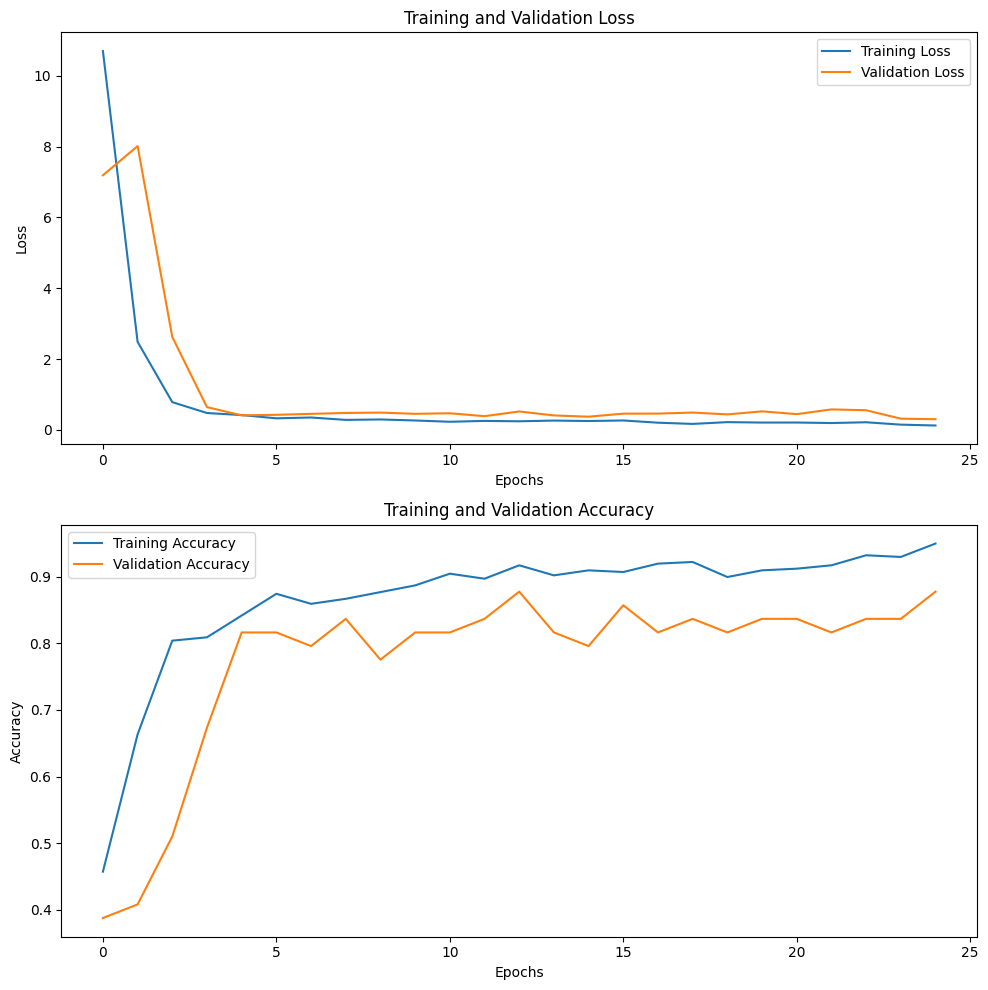

Test Accuracy: 0.9215686274509803


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from sklearn.metrics import accuracy_score
from google.colab import drive
import zipfile
from PIL import Image
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

path = '/content/drive/MyDrive/data/train.zip'
extract_path = '/content/drive/MyDrive/data/train'

# Ensure the zip file exists
if not os.path.exists(path):
    raise FileNotFoundError(f"Zip file '{path}' does not exist. Please check the path.")

# Extract the zip file if the directory does not exist
if not os.path.exists(extract_path):
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Ensure subdirectories exist
classes = ['COVID', 'Normal', 'Pneumonia']
for cls in classes:
    if not os.path.exists(os.path.join(extract_path, 'train', cls)):
        raise FileNotFoundError(f"Subdirectory '{os.path.join(extract_path, 'train', cls)}' does not exist. Please check the path.")

# Custom Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load image paths and labels
image_paths = []
labels = []

for idx, cls in enumerate(classes):
    cls_dir = os.path.join(extract_path, 'train', cls)
    cls_paths = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir) if img.endswith('.jpg')]
    image_paths.extend(cls_paths)
    labels.extend([idx] * len(cls_paths))

# Define transforms with data augmentation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the dataset
dataset = CustomImageDataset(image_paths, labels, transform=transform)

# Split the data into training, devset, and test sets
partitions = [0.8, 0.1, 0.1]

train_size = int(partitions[0] * len(dataset))
test_dev_size = len(dataset) - train_size
dev_size = int(partitions[1] * len(dataset))
test_size = test_dev_size - dev_size

train_data, test_dev_data = random_split(dataset, [train_size, test_dev_size])
dev_data, test_data = random_split(test_dev_data, [dev_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 18 * 18, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer with weight decay
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Weight decay term added

# Function to train and validate the model
def train_validate(model, train_loader, dev_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in dev_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(dev_loader))
        val_accuracies.append(correct / total)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss/len(dev_loader)}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train and validate the model
num_epochs = 25
train_losses, val_losses, train_accuracies, val_accuracies = train_validate(model, train_loader, dev_loader, criterion, optimizer, num_epochs)

# Plotting the results
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(range(num_epochs), train_losses, label='Training Loss')
axs[0].plot(range(num_epochs), val_losses, label='Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='best')
axs[0].set_title('Training and Validation Loss')

axs[1].plot(range(num_epochs), train_accuracies, label='Training Accuracy')
axs[1].plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='best')
axs[1].set_title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())

accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy}')

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/x0.2.pth')


#Activation and optimizers
##Learning Rate Scheduling: Using StepLR to reduce the learning rate by a factor of 0.1 every 7 epochs.
##Additional Data Augmentation: Adding random horizontal flip and random rotation
##ReLU Activation Function:
##Applied after each convolutional and fully connected layer to introduce non-linearity.
##Helps the model to learn complex patterns.
##Adam Optimizer:
##Used for updating the model parameters to minimize the loss function.
##Adaptive learning rate and moment estimation help in achieving efficient training.


Mounted at /content/drive
Epoch 1/25, Train Loss: 14.357951888671288, Val Loss: 14.58364200592041, Train Acc: 0.4748743718592965, Val Acc: 0.3469387755102041
Epoch 2/25, Train Loss: 3.4201685717472663, Val Loss: 11.100597381591797, Train Acc: 0.6381909547738693, Val Acc: 0.3469387755102041
Epoch 3/25, Train Loss: 1.2620488588626568, Val Loss: 2.707220435142517, Train Acc: 0.7512562814070352, Val Acc: 0.46938775510204084
Epoch 4/25, Train Loss: 0.728773771570279, Val Loss: 1.1150107979774475, Train Acc: 0.7814070351758794, Val Acc: 0.673469387755102
Epoch 5/25, Train Loss: 0.4727715930113426, Val Loss: 0.8822512328624725, Train Acc: 0.8065326633165829, Val Acc: 0.6530612244897959
Epoch 6/25, Train Loss: 0.47942904325631946, Val Loss: 0.5315467938780785, Train Acc: 0.7989949748743719, Val Acc: 0.8163265306122449
Epoch 7/25, Train Loss: 0.405846622127753, Val Loss: 0.4214561805129051, Train Acc: 0.8417085427135679, Val Acc: 0.8775510204081632
Epoch 8/25, Train Loss: 0.29762753271139586, V

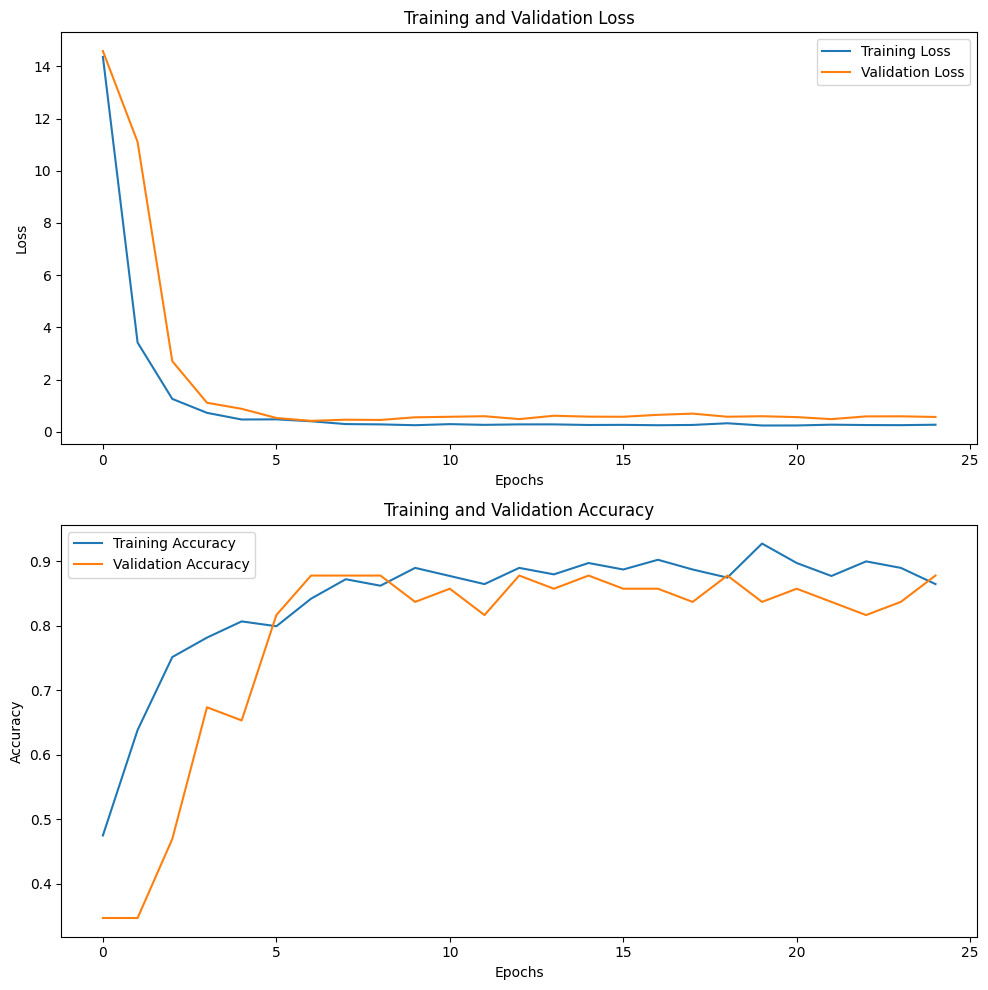

Test Accuracy: 0.9019607843137255


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from sklearn.metrics import accuracy_score
from google.colab import drive
import zipfile
from PIL import Image
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

path = '/content/drive/MyDrive/data/train.zip'
extract_path = '/content/drive/MyDrive/data/train'

# Ensure the zip file exists
if not os.path.exists(path):
    raise FileNotFoundError(f"Zip file '{path}' does not exist. Please check the path.")

# Extract the zip file if the directory does not exist
if not os.path.exists(extract_path):
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Ensure subdirectories exist
classes = ['COVID', 'Normal', 'Pneumonia']
for cls in classes:
    if not os.path.exists(os.path.join(extract_path, 'train', cls)):
        raise FileNotFoundError(f"Subdirectory '{os.path.join(extract_path, 'train', cls)}' does not exist. Please check the path.")

# Custom Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load image paths and labels
image_paths = []
labels = []

for idx, cls in enumerate(classes):
    cls_dir = os.path.join(extract_path, 'train', cls)
    cls_paths = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir) if img.endswith('.jpg')]
    image_paths.extend(cls_paths)
    labels.extend([idx] * len(cls_paths))

# Define transforms with data augmentation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the dataset
dataset = CustomImageDataset(image_paths, labels, transform=transform)

# Split the data into training, devset, and test sets
partitions = [0.8, 0.1, 0.1]

train_size = int(partitions[0] * len(dataset))
test_dev_size = len(dataset) - train_size
dev_size = int(partitions[1] * len(dataset))
test_size = test_dev_size - dev_size

train_data, test_dev_data = random_split(dataset, [train_size, test_dev_size])
dev_data, test_data = random_split(test_dev_data, [dev_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 18 * 18, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer with weight decay
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Weight decay term added

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Function to train and validate the model
def train_validate(model, train_loader, dev_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in dev_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(dev_loader))
        val_accuracies.append(correct / total)

        # Step the scheduler
        scheduler.step()

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss/len(dev_loader)}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train and validate the model with the scheduler
num_epochs = 25
train_losses, val_losses, train_accuracies, val_accuracies = train_validate(model, train_loader, dev_loader, criterion, optimizer, scheduler, num_epochs)

# Plotting the results
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(range(num_epochs), train_losses, label='Training Loss')
axs[0].plot(range(num_epochs), val_losses, label='Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='best')
axs[0].set_title('Training and Validation Loss')

axs[1].plot(range(num_epochs), train_accuracies, label='Training Accuracy')
axs[1].plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='best')
axs[1].set_title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())

accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy}')

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/x0.3.pth')


# Deeper Model construction
## Add more convolutional, batch normalization, and pooling layers, as well as additional fully connected layers
## Double the epochs to 50

Mounted at /content/drive
Epoch 1/50, Train Loss: 1.910743589584644, Val Loss: 1.4048065543174744, Train Acc: 0.457286432160804, Val Acc: 0.30612244897959184
Epoch 2/50, Train Loss: 0.7562305422929617, Val Loss: 1.9650510549545288, Train Acc: 0.6306532663316583, Val Acc: 0.3469387755102041
Epoch 3/50, Train Loss: 0.5917539986280295, Val Loss: 1.9364140033721924, Train Acc: 0.7386934673366834, Val Acc: 0.30612244897959184
Epoch 4/50, Train Loss: 0.5499553451171288, Val Loss: 0.5487808138132095, Train Acc: 0.7814070351758794, Val Acc: 0.7551020408163265
Epoch 5/50, Train Loss: 0.5444735036446497, Val Loss: 1.0314880013465881, Train Acc: 0.7512562814070352, Val Acc: 0.5714285714285714
Epoch 6/50, Train Loss: 0.47831029960742366, Val Loss: 0.6288325786590576, Train Acc: 0.7839195979899497, Val Acc: 0.7142857142857143
Epoch 7/50, Train Loss: 0.45013888294880205, Val Loss: 0.8284239172935486, Train Acc: 0.8190954773869347, Val Acc: 0.6122448979591837
Epoch 8/50, Train Loss: 0.410059070357909

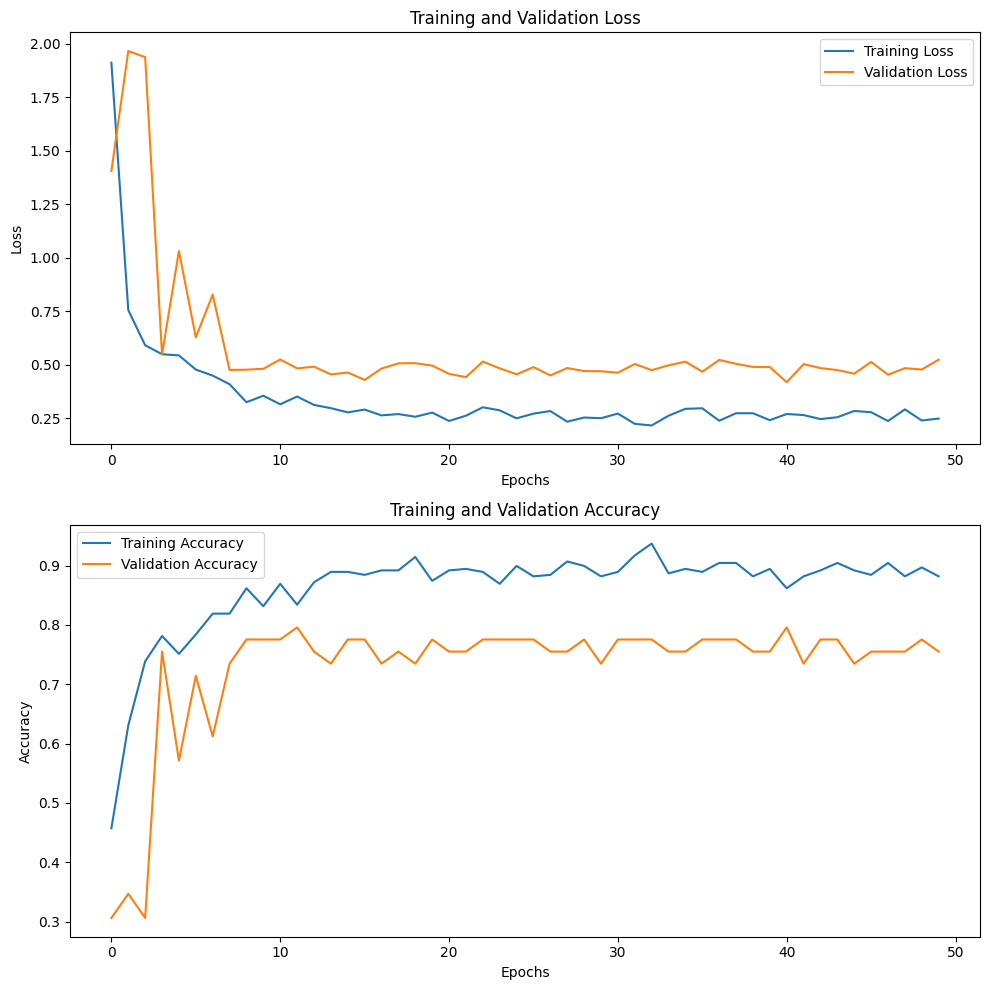

Test Accuracy: 0.9019607843137255


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from sklearn.metrics import accuracy_score
from google.colab import drive
import zipfile
from PIL import Image
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

path = '/content/drive/MyDrive/data/train.zip'
extract_path = '/content/drive/MyDrive/data/train'

# Ensure the zip file exists
if not os.path.exists(path):
    raise FileNotFoundError(f"Zip file '{path}' does not exist. Please check the path.")

# Extract the zip file if the directory does not exist
if not os.path.exists(extract_path):
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Ensure subdirectories exist
classes = ['COVID', 'Normal', 'Pneumonia']
for cls in classes:
    if not os.path.exists(os.path.join(extract_path, 'train', cls)):
        raise FileNotFoundError(f"Subdirectory '{os.path.join(extract_path, 'train', cls)}' does not exist. Please check the path.")

# Custom Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load image paths and labels
image_paths = []
labels = []

for idx, cls in enumerate(classes):
    cls_dir = os.path.join(extract_path, 'train', cls)
    cls_paths = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir) if img.endswith('.jpg')]
    image_paths.extend(cls_paths)
    labels.extend([idx] * len(cls_paths))

# Define transforms with data augmentation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the dataset
dataset = CustomImageDataset(image_paths, labels, transform=transform)

# Split the data into training, devset, and test sets
partitions = [0.8, 0.1, 0.1]

train_size = int(partitions[0] * len(dataset))
test_dev_size = len(dataset) - train_size
dev_size = int(partitions[1] * len(dataset))
test_size = test_dev_size - dev_size

train_data, test_dev_data = random_split(dataset, [train_size, test_dev_size])
dev_data, test_data = random_split(test_dev_data, [dev_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Define the deeper CNN model
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Additional layers
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(512 * 4 * 4, 1024)  # Adjust input dimensions based on pooling
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, 3)  # Assuming 3 output classes

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = x.view(-1, 512 * 4 * 4)  # Adjust based on final feature map size
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer with weight decay
model = DeeperCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Weight decay term added

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Function to train and validate the model
def train_validate(model, train_loader, dev_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in dev_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(dev_loader))
        val_accuracies.append(correct / total)

        # Step the scheduler
        scheduler.step()

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss/len(dev_loader)}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train and validate the model with the scheduler
num_epochs = 50
train_losses, val_losses, train_accuracies, val_accuracies = train_validate(model, train_loader, dev_loader, criterion, optimizer, scheduler, num_epochs)

# Plotting the results
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(range(num_epochs), train_losses, label='Training Loss')
axs[0].plot(range(num_epochs), val_losses, label='Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='best')
axs[0].set_title('Training and Validation Loss')

axs[1].plot(range(num_epochs), train_accuracies, label='Training Accuracy')
axs[1].plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='best')
axs[1].set_title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())

accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy}')

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/x0.4_deeper.pth')


#Model enhancement

Mounted at /content/drive
Epoch 1/100, Train Loss: 2.032898384791154, Val Loss: 1.2048447132110596, Train Acc: 0.46733668341708545, Val Acc: 0.40816326530612246
Epoch 2/100, Train Loss: 0.7394867699879867, Val Loss: 0.5325148850679398, Train Acc: 0.6381909547738693, Val Acc: 0.8163265306122449
Epoch 3/100, Train Loss: 0.7315052426778353, Val Loss: 1.225170373916626, Train Acc: 0.678391959798995, Val Acc: 0.42857142857142855
Epoch 4/100, Train Loss: 0.6391221766288464, Val Loss: 0.4790886715054512, Train Acc: 0.7110552763819096, Val Acc: 0.7959183673469388
Epoch 5/100, Train Loss: 0.5634313340370471, Val Loss: 0.42782387137413025, Train Acc: 0.7788944723618091, Val Acc: 0.8571428571428571
Epoch 6/100, Train Loss: 0.5048131071604215, Val Loss: 1.042086124420166, Train Acc: 0.7864321608040201, Val Acc: 0.5714285714285714
Epoch 7/100, Train Loss: 0.5214557911341007, Val Loss: 0.4095117598772049, Train Acc: 0.7713567839195979, Val Acc: 0.8775510204081632
Epoch 8/100, Train Loss: 0.454661467

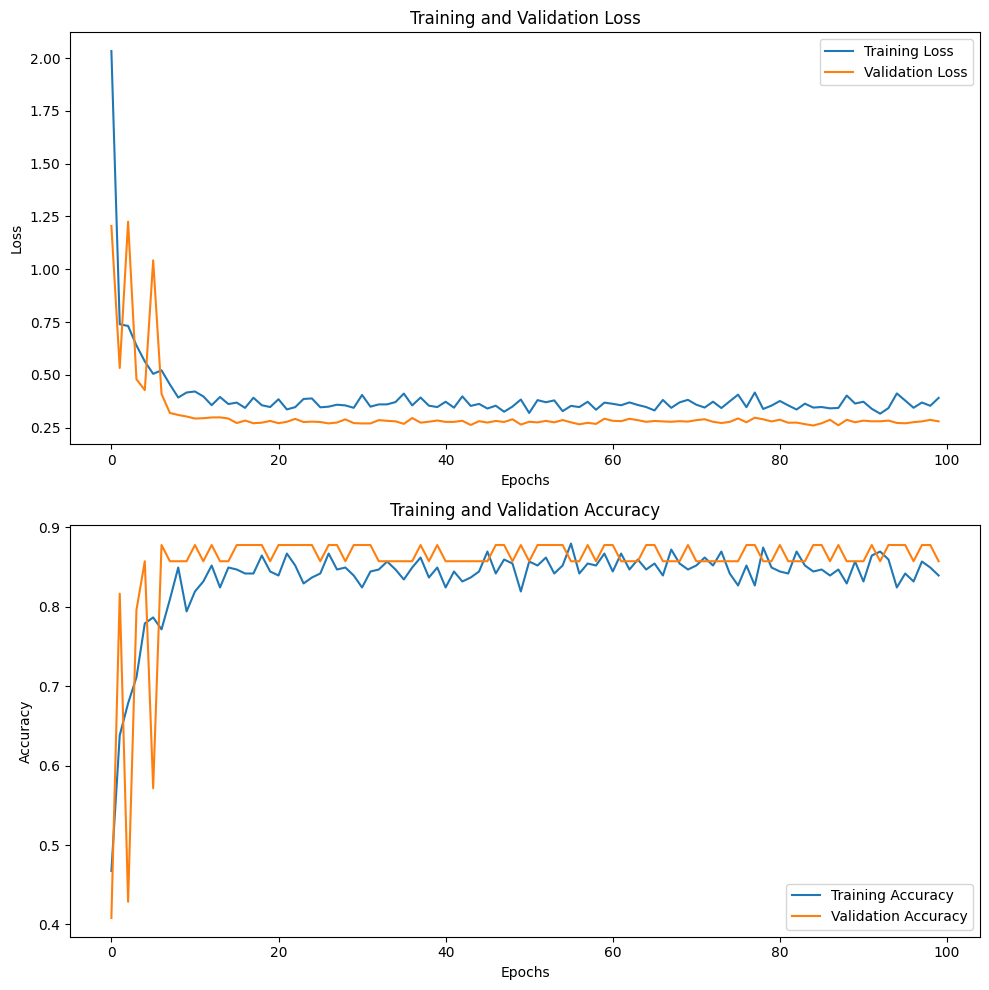

Test Accuracy: 0.7254901960784313


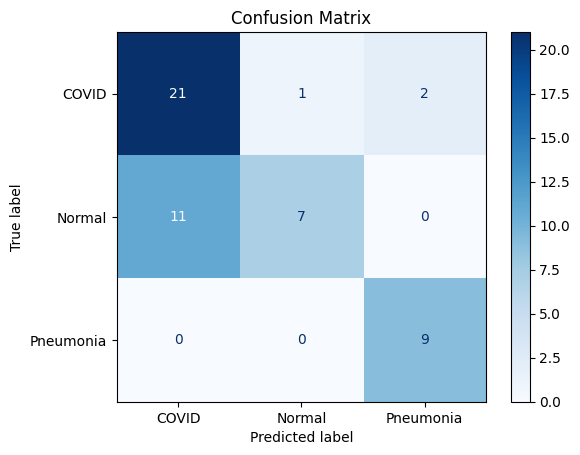

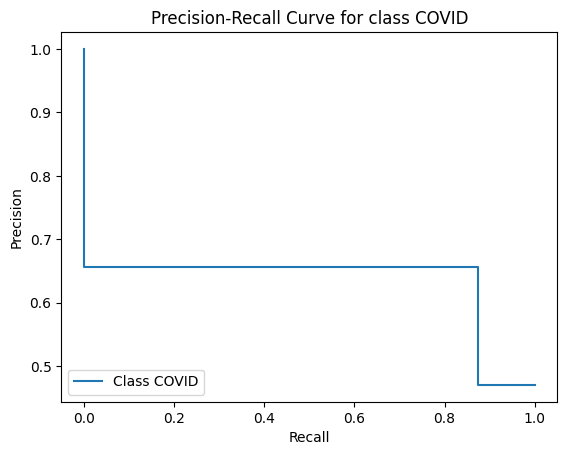

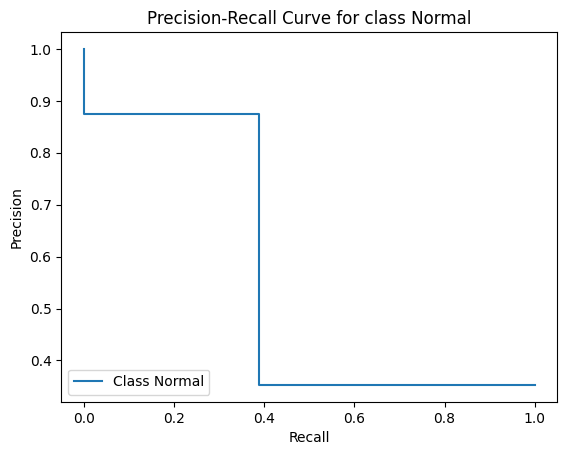

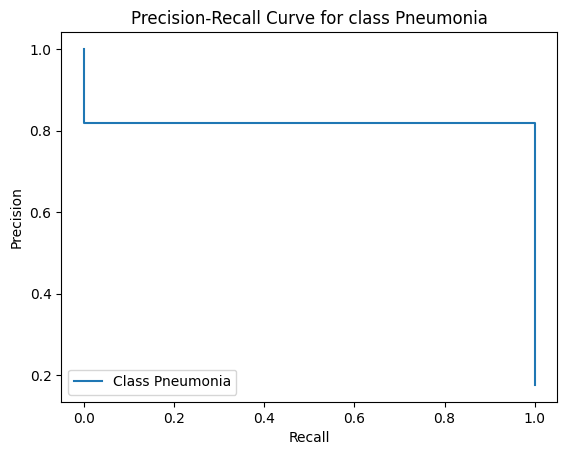

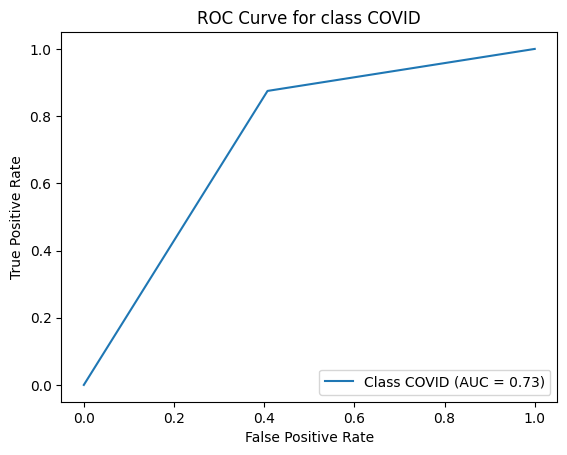

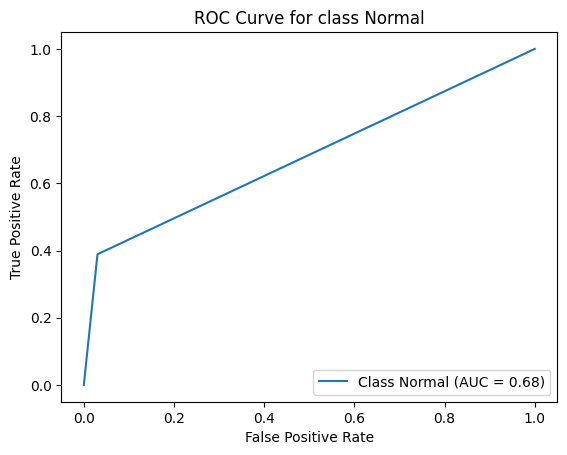

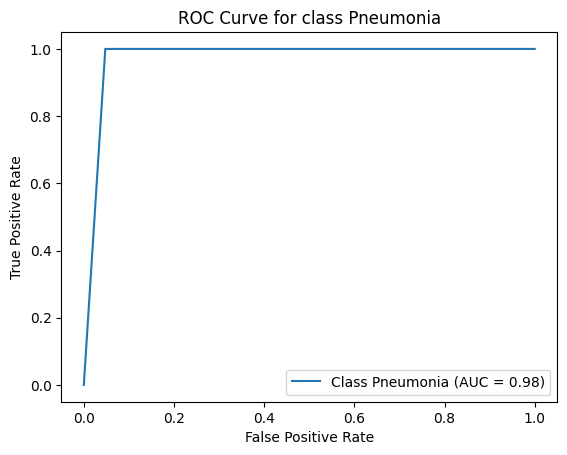

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, roc_curve, auc, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
from google.colab import drive
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import copy

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

path = '/content/drive/MyDrive/data/train.zip'
extract_path = '/content/drive/MyDrive/data/train'

# Ensure the zip file exists
if not os.path.exists(path):
    raise FileNotFoundError(f"Zip file '{path}' does not exist. Please check the path.")

# Extract the zip file if the directory does not exist
if not os.path.exists(extract_path):
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Ensure subdirectories exist
classes = ['COVID', 'Normal', 'Pneumonia']
for cls in classes:
    if not os.path.exists(os.path.join(extract_path, 'train', cls)):
        raise FileNotFoundError(f"Subdirectory '{os.path.join(extract_path, 'train', cls)}' does not exist. Please check the path.")

# Custom Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load image paths and labels
image_paths = []
labels = []

for idx, cls in enumerate(classes):
    cls_dir = os.path.join(extract_path, 'train', cls)
    cls_paths = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir) if img.endswith('.jpg')]
    image_paths.extend(cls_paths)
    labels.extend([idx] * len(cls_paths))

# Define transforms with data augmentation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the dataset
dataset = CustomImageDataset(image_paths, labels, transform=transform)

# Split the data into training, devset, and test sets
partitions = [0.8, 0.1, 0.1]

train_size = int(partitions[0] * len(dataset))
test_dev_size = len(dataset) - train_size
dev_size = int(partitions[1] * len(dataset))
test_size = test_dev_size - dev_size

train_data, test_dev_data = random_split(dataset, [train_size, test_dev_size])
dev_data, test_data = random_split(test_dev_data, [dev_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Define the deeper CNN model
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Additional layers
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(512 * 4 * 4, 1024)  # Adjust input dimensions based on pooling
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, 3)  # Assuming 3 output classes

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = x.view(-1, 512 * 4 * 4)  # Adjust based on final feature map size
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer with weight decay
model = DeeperCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Weight decay term added

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Function to train and validate the model
def train_validate(model, train_loader, dev_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in dev_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(dev_loader))
        val_accuracies.append(correct / total)

        if val_accuracies[-1] > best_acc:
            best_acc = val_accuracies[-1]
            best_model_wts = copy.deepcopy(model.state_dict())

        # Step the scheduler
        scheduler.step()

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss/len(dev_loader)}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), '/content/drive/MyDrive/x0.5(best model).pth')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train and validate the model with the scheduler
num_epochs = 100
train_losses, val_losses, train_accuracies, val_accuracies = train_validate(model, train_loader, dev_loader, criterion, optimizer, scheduler, num_epochs)

# Plotting the results
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(range(num_epochs), train_losses, label='Training Loss')
axs[0].plot(range(num_epochs), val_losses, label='Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='best')
axs[0].set_title('Training and Validation Loss')

axs[1].plot(range(num_epochs), train_accuracies, label='Training Accuracy')
axs[1].plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='best')
axs[1].set_title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())

accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy}')

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Calculate and plot precision-recall curve for each class
for i in range(3):
    precision, recall, _ = precision_recall_curve(np.array(y_true) == i, np.array(y_pred) == i)
    pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name=f'Class {classes[i]}')
    pr_display.plot()
    plt.title(f'Precision-Recall Curve for class {classes[i]}')
    plt.show()

# Calculate and plot ROC curve for each class
for i in range(3):
    fpr, tpr, _ = roc_curve(np.array(y_true) == i, np.array(y_pred) == i)
    roc_auc = auc(fpr, tpr)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f'Class {classes[i]}')
    roc_display.plot()
    plt.title(f'ROC Curve for class {classes[i]}')
    plt.show()
